In [4]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [5]:
TEST_SIZE = 100
SELECTION_RATES = [0.1, 0.25, 0.5]
NUM_SPLITS = 5
ITERATIONS_PER_SPLIT = 20

In [9]:
full_df = pd.read_csv("predictions/heloc/model_predictions.csv")
NUM_MODELS = len(full_df.columns)-3
full_df.head()

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,y,idx,seed
0,0.800000,0.720000,0.880000,0.680000,0.68000,0.76000,0.760000,0.640000,0.720000,0.880000,1,3654,0
1,0.460438,0.469075,0.448139,0.439215,0.43974,0.44465,0.456582,0.421386,0.418838,0.432384,1,8612,0
2,0.200000,0.280000,0.160000,0.160000,0.28000,0.16000,0.120000,0.200000,0.080000,0.040000,0,2873,0
3,0.840000,0.760000,0.920000,0.880000,0.84000,0.88000,0.840000,0.920000,0.800000,0.920000,1,6983,0
4,0.480000,0.640000,0.440000,0.480000,0.56000,0.36000,0.400000,0.440000,0.720000,0.320000,0,2192,0


In [10]:
def calculate_unique_allocations(k):
    # 1 -- What is the best precision?
    precision = {}
    for model in range(1, NUM_MODELS+1):
        allocation = df["p_"+str(model)].nlargest(k).index.to_list()
        precision[model] = int(df.loc[allocation, "y"].sum())
    best_precision = max(precision.values())

    # 2 -- Among models with best precision, calculate allocations    
    allocations = set()
    allocations_growth = []
    qualified_selections = []
    unqualified_selections = []
    for model in range(1, NUM_MODELS+1):
        if precision[model] != best_precision:
            if len(allocations_growth) == 0:
                allocations_growth.append(0)
            else:
                allocations_growth.append(allocations_growth[-1])
            continue
        
        allocation = df["p_"+str(model)].nlargest(k).index.to_list()

        selected = df.loc[allocation] 
        qualified_selections.append(selected[selected["y"]==1].index.to_list())
        unqualified_selections.append(selected[selected["y"]==0].index.to_list())
        
        allocation.sort()
        allocation = tuple(allocation)
        allocations.add(allocation)
        allocations_growth.append(len(allocations))

    qualified_selections = [item for sublist in qualified_selections for item in sublist]
    unqualified_selections = [item for sublist in unqualified_selections for item in sublist]
    qualified_count = dict(Counter(qualified_selections))
    unqualified_count = dict(Counter(unqualified_selections))
    
    return allocations_growth, best_precision, qualified_count.values(), unqualified_count.values()

## Homogenization: Unique Allocations with Equally-High Utility

In [11]:
results = []
allocations_growth = {}
qualified_count = {}
unqualified_count = {}
for rate in SELECTION_RATES:
    allocations_growth[rate] = []
    qualified_count[rate] = []
    unqualified_count[rate] = []

for split in range(NUM_SPLITS):
    print("Train-Test Split:", split)
    split_df = full_df[full_df["seed"]==split].copy()
    
    for i in tqdm(range(ITERATIONS_PER_SPLIT)):
        df = split_df.sample(n=TEST_SIZE, random_state=i)
    
        for rate in SELECTION_RATES:
            k = int(rate * len(df))
            allocations, precision, qc, uqc = calculate_unique_allocations(k)
            allocations_growth[rate].append(allocations)
            qualified_count[rate].append(qc)
            unqualified_count[rate].append(uqc)
            
            result = {"k": k, "n": TEST_SIZE, "k'": precision, "n'": df["y"].sum(), "allocations_found": max(allocations)}
            results.append(result)

Train-Test Split: 0


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 84.53it/s]


Train-Test Split: 1


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 97.74it/s]


Train-Test Split: 2


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 97.12it/s]


Train-Test Split: 3


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 100.08it/s]


Train-Test Split: 4


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 97.82it/s]


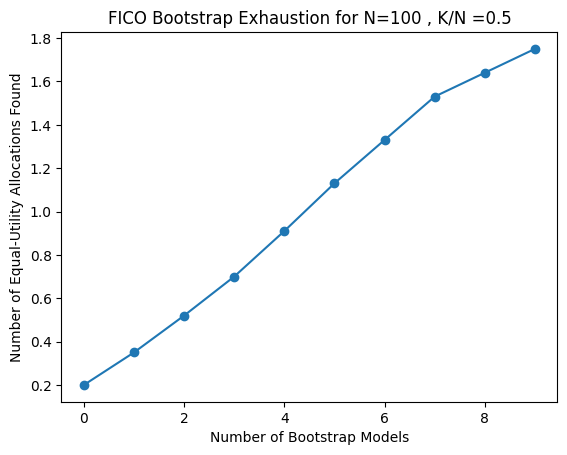

In [12]:
k_n = 0.50
data = np.array(allocations_growth[k_n])
data = np.mean(data, axis=0)

x = np.arange(len(data))
plt.plot(x, data, marker='o')

plt.title('FICO Bootstrap Exhaustion for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.xlabel('Number of Bootstrap Models')
plt.ylabel('Number of Equal-Utility Allocations Found')

plt.show()

## Individual Fairness: Selection Frequency

In [13]:
for rate in SELECTION_RATES:
    qualified_count[rate] = [item for sublist in qualified_count[rate] for item in sublist]
    unqualified_count[rate] = [item for sublist in unqualified_count[rate] for item in sublist]

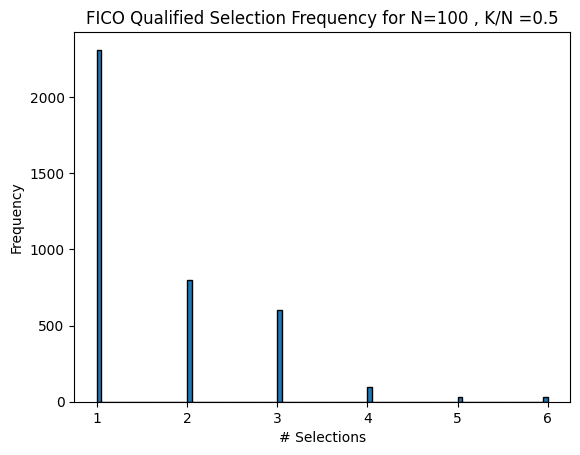

In [14]:
k_n = 0.50
plt.hist(qualified_count[k_n], bins=100, edgecolor='black')

plt.xlabel('# Selections')
plt.ylabel('Frequency')
plt.title('FICO Qualified Selection Frequency for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.show()

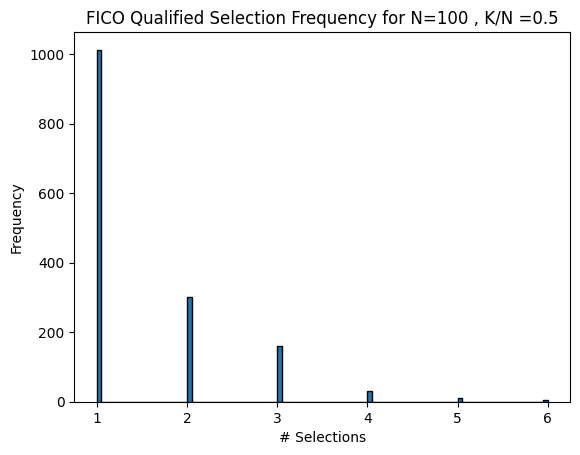

In [15]:
k_n = 0.50
plt.hist(unqualified_count[k_n], bins=100, edgecolor='black')

plt.xlabel('# Selections')
plt.ylabel('Frequency')
plt.title('FICO Qualified Selection Frequency for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.show()